In [1]:
import numpy as np
import json
import pandas as pd


from matrix_class import ProteinMatrix
from matrix_class import SubMatrix
from cluster_class import AllClusters
from degreelist_class import DegreeList


from connected_components_utils import *
from analysis_utils import *

from func_e.FUNC_E import FUNC_E # import the class
import func_e.vocabs.all as vocabs

In [2]:
dream3_cluster_dict_file = "../data/results/DREAM-3-cc/d3_5_100.json-cluster.json"
dict_of_clusters = {}
# # convert actual cluster file to a dictionary!!
with open(dream3_cluster_dict_file,"r") as cluster_dict_file:
    dict_of_clusters = json.load(cluster_dict_file)

In [3]:
matrix, clusters, degreelist = initialize_matrix_clusters_degreelist("../data/networks/DREAM_files/dream_3.txt", "../data/results/DREAM-3-cc/d3_5_100.json-cluster.json")

In [4]:
genomic_background_filepath = '../data/testing_data/protein_list.txt'
all_go_terms = vocabs.getTerms(['GO'])
term_mapping_filepath = 'term_mapping.txt'
create_term_mapping_list('../data/go-results/dream_3_go_results.tsv', term_mapping_filepath)

In [5]:
og_clusters_querylist_path = 'original_querylist.txt'
clusters.print_querylist_of_clusters_to_file([*range(clusters.get_num_clusters())]
, og_clusters_querylist_path)


original_fe = FUNC_E()
original_fe.importFiles({
    'background': genomic_background_filepath, 
    'terms2features': term_mapping_filepath })
original_fe.setTerms(all_go_terms)
original_fe.setEnrichmentSettings({'ecut': 0.01})

original_fe.importFiles({'query': og_clusters_querylist_path })
original_fe.run(cluster=False)

/Users/charlotte/miniconda3/envs/diamonds/lib/python3.10/site-packages/func_e/FUNC_E.py:279: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  modResults = modResults.append({
/Users/charlotte/miniconda3/envs/diamonds/lib/python3.10/site-packages/func_e/FUNC_E.py:279: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  modResults = modResults.append({
/Users/charlotte/miniconda3/envs/diamonds/lib/python3.10/site-packages/func_e/FUNC_E.py:279: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  modResults = modResults.append({
/Users/charlotte/miniconda3/envs/diamonds/lib/python3.10/site-packages/func_e/FUNC_E.py:279: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat 

In [6]:
original_df = original_fe.enrichment[['Module', 'Term', 'Fishers_pvalue']].copy()
original_df['Module'] = original_df['Module'] + ' ' + original_df['Term']
original_df.drop('Term', axis=1, inplace=True)

### Now: will create different sets of proteins to add back etc

#### take 1: 

step 1: find qualifying proteins and clusters with very strict cutoff, and initialize clusters

In [7]:
qualifying_clusters_1, qualifying_proteins_1 = find_clusters_and_proteins_together(matrix, clusters, degreelist, cluster_ratio=.90, min_components_that_protein_connects=3)

In [10]:
print(qualifying_clusters_1)
print(qualifying_proteins_1)

[25, 152, 161, 185]
{25: ['AKT1', 'SRC'], 152: ['PPM1A', 'PPP2CA', 'CDK2', 'GSK3B', 'MAPK3', 'CSNK2A1', 'PRKACA', 'SRC'], 161: ['SNCA', 'LRP6', 'RPS6KA1', 'NFE2L2', 'ESR1', 'GRB2', 'PLK1', 'STAT3', 'MAPK8', 'ABL1', 'MAPK14', 'GSK3B', 'TP53', 'AKT1', 'CSNK2A1', 'CDK1', 'PRKCA'], 185: ['TSC1', 'IKBKB']}


In [31]:
# new_clusters_1 = AllClusters(protein_to_cluster_dict=dict_of_clusters)
# print(new_clusters_1.get_cluster_proteins(152))
# print(clusters.get_cluster_proteins(152))


# print("")
# new_clusters_1 = modified_clusters(new_clusters_1, qualifying_proteins_1)
# print(new_clusters_1.get_cluster_proteins(152))
#TODO: ERRORRRRR original clusters get their cluster proteins updated as well. 


In [35]:
# from analysis_utils import print_both_querylists_to_files
# from analysis_utils import get_initialized_fe

step 2: run functional enrichment
    a. create og and new querylists
    b. create a comparison and new functional enrichment with querylists as input
    c. run both functional enrichments

In [12]:
original_clusters_querylist_1 = 'og_querylist_1.txt'
updated_clusters_querylist_1 = 'new_querylist_1.txt'

In [51]:
# original:
print_querylist_of_clusters_to_file(clusters, qualifying_clusters_1,original_clusters_querylist_1)

# clusters with added proteins:
print_querylist_of_clusters_to_file(clusters, qualifying_clusters_1, updated_clusters_querylist_1, qualifying_proteins_1)

In [52]:
original_fe_1 = get_initialized_fe(genomic_background_filepath, term_mapping_filepath, termlist = all_go_terms)

updated_fe_1 = get_initialized_fe(genomic_background_filepath, term_mapping_filepath, termlist = all_go_terms)


In [ ]:
original_fe_1.importFiles({'query': original_clusters_querylist_1 })
original_fe_1.run(cluster=False)

updated_fe_1.importFiles({'query': updated_clusters_querylist_1 })
updated_fe_1.run(cluster=False)

step 3: from functional enrichment, assemble data/p-values
    a. get original and updated pvals
    b. combine in a single dataframe

In [54]:
original_df_1 = original_fe_1.enrichment[['Module', 'Term', 'Fishers_pvalue']].copy()
original_df_1['Module'] = original_df_1['Module'] + ' ' + original_df_1['Term']
original_df_1.drop('Term', axis=1, inplace=True)

In [55]:
original_df_1


,Module,Fishers_pvalue
0,cluster_161 GO:0030175,0.002023
1,cluster_161 GO:0032465,0.007341
2,cluster_185 GO:0016241,0.007339
3,cluster_185 GO:0016485,0.005832
4,cluster_185 GO:0030216,0.004486
5,cluster_185 GO:0055038,0.007339
6,cluster_185 GO:0070507,0.002297
7,cluster_185 GO:0072659,0.001876
8,cluster_25 GO:0007346,0.007487
9,cluster_25 GO:0032728,0.005714


In [56]:
updated_df_1 = updated_fe_1.enrichment[['Module', 'Term', 'Fishers_pvalue']].copy()

updated_df_1['Module'] = updated_df_1['Module'] + ' ' + updated_df_1['Term']
updated_df_1.drop('Term', axis=1, inplace=True)
updated_df_1.rename(columns = {'Fishers_pvalue':'Updated_Fishers_pvalue'}, inplace = True)

In [59]:
updated_df_1
print(updated_df_1)

                    Module Updated_Fishers_pvalue
0   cluster_152 GO:0005739               0.004911
1   cluster_152 GO:0018105               0.000449
2   cluster_152 GO:0046827               0.001368
3   cluster_161 GO:0004707               0.009507
4   cluster_161 GO:0007173               0.006526
5   cluster_161 GO:0007265               0.008565
6   cluster_161 GO:0008286               0.009345
7   cluster_161 GO:0018105               0.000277
8   cluster_161 GO:0018107               0.001944
9   cluster_161 GO:0032436               0.004365
10  cluster_161 GO:0032465               0.007713
11  cluster_161 GO:0035723               0.007985
12  cluster_161 GO:0043154               0.005928
13  cluster_161 GO:0071479               0.004573
14  cluster_161 GO:1900182               0.009708
15  cluster_161 GO:2000379               0.002884
16  cluster_185 GO:0006417               0.004975
17  cluster_185 GO:0016239               0.004556
18  cluster_185 GO:0016485               0.009493


In [57]:
results_df_1 = pd.merge(original_df_1, updated_df_1, on=['Module'], how='outer')
results_df_1

,Module,Fishers_pvalue,Updated_Fishers_pvalue
0,cluster_161 GO:0030175,0.002023,NaN
1,cluster_161 GO:0032465,0.007341,0.007713
2,cluster_185 GO:0016241,0.007339,NaN
3,cluster_185 GO:0016485,0.005832,0.009493
4,cluster_185 GO:0030216,0.004486,0.007322
5,cluster_185 GO:0055038,0.007339,NaN
6,cluster_185 GO:0070507,0.002297,0.00377
7,cluster_185 GO:0072659,0.001876,0.000295
8,cluster_25 GO:0007346,0.007487,NaN
9,cluster_25 GO:0032728,0.005714,NaN


step 4: display results in a graph

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
print(results_df_1)

<AxesSubplot:xlabel='Module'>

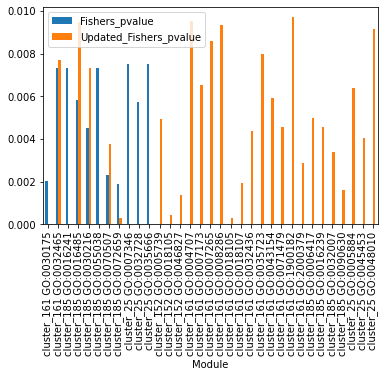

In [58]:
results_df_1.plot(x="Module", y=["Fishers_pvalue", "Updated_Fishers_pvalue"], kind="bar")

this graph ^ is interesting bc it shows that p-values increase (less significant). this shows that maybe we are adding proteins to the wrong clusters. it will be interesting to go back and tweak the functions and see how adding different things affects everything

In [102]:
changes_df_1 = (results_df_1.copy()).dropna(axis=0)

<AxesSubplot:xlabel='Module'>

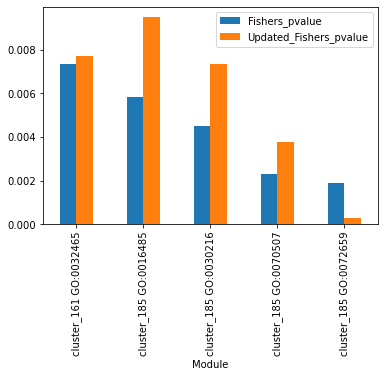

In [103]:
changes_df_1.plot(x="Module", y=["Fishers_pvalue", "Updated_Fishers_pvalue"], kind="bar")

^ this graph too, bc ur just adding proteins to clusters and then the proteins aren't actually enhancing the functional enrichment of the clusters

### NOW! will find clusters that were previously not qualifying. the qualifying clusters will now be those that are super disconnected!

In [80]:
# am now changing this function to find highly unconnectged cllsters!
def find_clusters_and_proteins_together(matrix: ProteinMatrix, clusters: AllClusters, degreelist: DegreeList, cluster_ratio: float = .05, cluster_constant: int = 0, protein_ratio: float = .05, protein_constant: int = 2, min_components_that_protein_connects: int = -1, max_degree: int = 500) -> list() and dict():
    """
    function is a version of find_clusters_that_match_criteria, that, once it finds the cluster, finds corresponding proteins at the same time so that the submatrix doesn't need to be reconstructed

    Parameters: 
        matrix - a ProteinMatrix of all protein interactions
        clusters - an AllClusters containing proteins grouped into clusters
        cluster_ratio and cluster_constant - used together to determine which clusters qualify, with the output of the function being cluster_ratio * input + cluster_constant
        TODO: remaining parameters
    Purpose:    determines clusters that are mostly highly connected, then 
                determines which proteins that, when added to the cluster, will 
                increase it's connectedness
    Returns:    a list containing the numbers of the clusters that qualify, and 
                a dictionary linking each cluster, to a list of the qualifying 
                proteins
    TODO: a cluster will qualify if -> IT IS HIGHLY UNCONNECTED
    """
    
    cluster_nums_that_qualify = list()
    qualifying_proteins_dict = dict()

    for cluster_num in clusters.get_all_clusters():
        # create a submatrix out of the proteins in the cluster
        submatrix = SubMatrix(clusters.get_cluster_proteins(cluster_num), matrix)
        num_components, labels = submatrix.get_num_components_and_labels()
        # print(f"num components is {num_components}. num proteins is {len(submatrix.get_list_of_proteins())}")
        if num_components > cluster_ratio * len(submatrix.get_list_of_proteins()) + cluster_constant:
            print(f"cluster {cluster_num} qualifies")
            # add cluster to list showing that it qualifies, 
            cluster_nums_that_qualify.append(cluster_num)

            # then do analysis on the cluster -> create a list of qualifying proteins
            qualifying_proteins = qualifying_proteins_using_submatrix(cluster_num, submatrix, clusters, degreelist, ratio=protein_ratio, constant=protein_constant, min_components_that_protein_connects=min_components_that_protein_connects, max_degree=max_degree)

            if qualifying_proteins: # not empty
                print(f"qualifying proteins {qualifying_proteins}")
                qualifying_proteins_dict[cluster_num] = qualifying_proteins
            


    return cluster_nums_that_qualify, qualifying_proteins_dict


In [81]:
qualifying_clusters_2, qualifying_proteins_2 = find_clusters_and_proteins_together(matrix, clusters, degreelist, cluster_ratio = 0.95, cluster_constant = 2, protein_constant=2, protein_ratio=.05)

cluster 62 qualifies
qualifying proteins ['ATM', 'CDK2', 'CDK1']
cluster 69 qualifies
qualifying proteins ['PRKCA']
cluster 96 qualifies
qualifying proteins ['CSNK2A1', 'CDK1', 'PRKACA', 'PRKCA']
cluster 98 qualifies
qualifying proteins ['MAPK14', 'CSNK2A1', 'CDK1', 'SRC']
cluster 134 qualifies
cluster 175 qualifies
qualifying proteins ['CDK1']


In [82]:
print(qualifying_proteins_2)
print(qualifying_clusters_2)

{62: ['ATM', 'CDK2', 'CDK1'], 69: ['PRKCA'], 96: ['CSNK2A1', 'CDK1', 'PRKACA', 'PRKCA'], 98: ['MAPK14', 'CSNK2A1', 'CDK1', 'SRC'], 175: ['CDK1']}
[62, 69, 96, 98, 134, 175]


now do functional enrichment:

In [84]:
original_clusters_querylist_2 = 'og_querylist_2.txt'
updated_clusters_querylist_2 = 'new_querylist_2.txt'

In [91]:
# original:
print_querylist_of_clusters_to_file(clusters, qualifying_clusters_1,original_clusters_querylist_2)

# clusters with added proteins:
print_querylist_of_clusters_to_file(clusters, qualifying_clusters_1, updated_clusters_querylist_2, qualifying_proteins_2)

In [93]:
original_fe_2 = get_initialized_fe(genomic_background_filepath, term_mapping_filepath, termlist = all_go_terms)

updated_fe_2 = get_initialized_fe(genomic_background_filepath, term_mapping_filepath, termlist = all_go_terms)

In [ ]:
original_fe_2.importFiles({'query': original_clusters_querylist_1 })
original_fe_2.run(cluster=False)

updated_fe_2.importFiles({'query': updated_clusters_querylist_1 })
updated_fe_2.run(cluster=False)

In [97]:
original_df_2 = original_fe_2.enrichment[['Module', 'Term', 'Fishers_pvalue']].copy()
original_df_2['Module'] = original_df_2['Module'] + ' ' + original_df_2['Term']
original_df_2.drop('Term', axis=1, inplace=True)

In [98]:
updated_df_2 = updated_fe_2.enrichment[['Module', 'Term', 'Fishers_pvalue']].copy()

updated_df_2['Module'] = updated_df_2['Module'] + ' ' + updated_df_2['Term']
updated_df_2.drop('Term', axis=1, inplace=True)
updated_df_2.rename(columns = {'Fishers_pvalue':'Updated_Fishers_pvalue'}, inplace = True)

In [100]:
results_df_2 = pd.merge(original_df_2, updated_df_2, on=['Module'], how='outer')
results_df_2

,Module,Fishers_pvalue,Updated_Fishers_pvalue
0,cluster_161 GO:0030175,0.002023,NaN
1,cluster_161 GO:0032465,0.007341,0.007713
2,cluster_185 GO:0016241,0.007339,NaN
3,cluster_185 GO:0016485,0.005832,0.009493
4,cluster_185 GO:0030216,0.004486,0.007322
5,cluster_185 GO:0055038,0.007339,NaN
6,cluster_185 GO:0070507,0.002297,0.00377
7,cluster_185 GO:0072659,0.001876,0.000295
8,cluster_25 GO:0007346,0.007487,NaN
9,cluster_25 GO:0032728,0.005714,NaN


<AxesSubplot:xlabel='Module'>

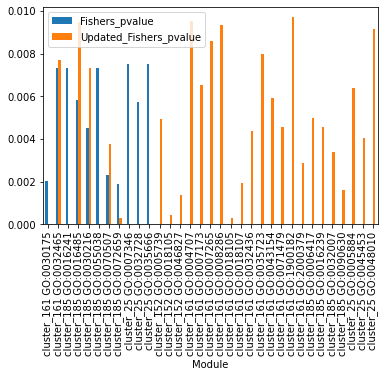

In [101]:
results_df_1.plot(x="Module", y=["Fishers_pvalue", "Updated_Fishers_pvalue"], kind="bar")

<AxesSubplot:xlabel='Module'>

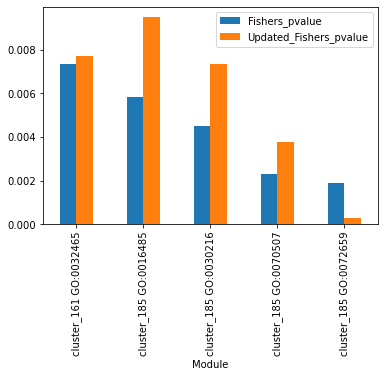

In [104]:
changes_df_2 = (results_df_2.copy()).dropna(axis=0)
changes_df_2.plot(x="Module", y=["Fishers_pvalue", "Updated_Fishers_pvalue"], kind="bar")